<a href="https://colab.research.google.com/github/jisoopak0822-ctrl/jisoopak/blob/main/Datamining_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {torch.cuda.get_device_properties(0).total_memory // (1024**2)} MB")


Using device: cpu


In [ ]:
#  Load Sentiment140 from LOCAL CSV
CSV_PATH = "training.1600000.processed.noemoticon.csv"

print("\nLoading Sentiment140 CSV...")
df = pd.read_csv(
    CSV_PATH,
    encoding="latin-1",
    header=None,
    names=["sentiment", "id", "date", "query", "user", "text"],
)
print("Raw shape:", df.shape)

# Keep only sentiment 0 (negative) and 4 (positive)
df = df[df["sentiment"].isin([0, 4])].reset_index(drop=True)
df["label"] = df["sentiment"].map({0: 0, 4: 1})  # 0 = negative, 1 = positive
print("\nLabel counts:\n", df["label"].value_counts())

# IMPORTANT: Sentiment140 training file is already balanced (0 and 4 are 800k each).
# Optionally subsample for faster experiments.
SUBSAMPLE = None  # e.g., 200000 for quicker runs; set to None for full dataset

if SUBSAMPLE is not None and SUBSAMPLE < len(df):
    neg_df = df[df["label"] == 0]
    pos_df = df[df["label"] == 1]
    n_per_class = min(SUBSAMPLE // 2, len(neg_df), len(pos_df))
    df = pd.concat(
        [
            neg_df.sample(n_per_class, random_state=RANDOM_SEED),
            pos_df.sample(n_per_class, random_state=RANDOM_SEED),
        ]
    ).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print("Dataset size after optional subsampling:", len(df))

texts = df["text"].tolist()
labels = df["label"].tolist()


Loading Sentiment140 CSV...
Raw shape: (1600000, 6)

Label counts:
 label
0    800000
1    800000
Name: count, dtype: int64
Dataset size after optional subsampling: 1600000



--- Transformer Baseline: DistilBERT (SST-2) ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


Running DistilBERT on 5000 tweets...

DistilBERT Baseline – Error Analysis:
Accuracy: 70.74%
False Positive Rate (FPR): 18.71%
False Negative Rate (FNR): 39.78%
Total Error Rate: 29.26%
Total Inference Time: 370.76 seconds


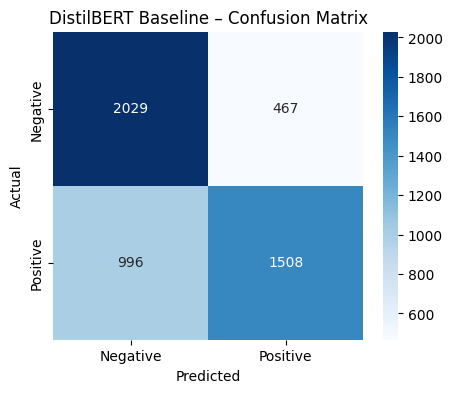

In [ ]:
# Optional Transformer Baseline (DistilBERT)
from transformers import pipeline

print("\n--- Transformer Baseline: DistilBERT (SST-2) ---")

BERT_SUBSAMPLE = 5000  # use a subset for speed; increase if your GPU is strong

if BERT_SUBSAMPLE is not None and BERT_SUBSAMPLE < len(df):
    bert_df = df.sample(BERT_SUBSAMPLE, random_state=RANDOM_SEED).reset_index(drop=True)
else:
    bert_df = df.copy()

bert_texts = bert_df["text"].tolist()
bert_true = bert_df["label"].tolist()

bert_device = 0 if torch.cuda.is_available() else -1
bert_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=bert_model_name, device=bert_device)

BERT_BATCH_SIZE = 32  # fixed batch size for controlled timing

start_time = time.time()
bert_pred = []

print(f"Running DistilBERT on {len(bert_texts)} tweets...")
for i in range(0, len(bert_texts), BERT_BATCH_SIZE):
    batch_texts = bert_texts[i:i + BERT_BATCH_SIZE]
    preds = sentiment_pipeline(batch_texts, truncation=True, batch_size=BERT_BATCH_SIZE)
    bert_pred.extend([0 if p["label"] == "NEGATIVE" else 1 for p in preds])

bert_time = time.time() - start_time

cm_bert = confusion_matrix(bert_true, bert_pred)
tn, fp, fn, tp = cm_bert.ravel()
bert_acc = accuracy_score(bert_true, bert_pred)
bert_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
bert_fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
bert_err = 1 - bert_acc

print("\nDistilBERT Baseline – Error Analysis:")
print(f"Accuracy: {bert_acc:.2%}")
print(f"False Positive Rate (FPR): {bert_fpr:.2%}")
print(f"False Negative Rate (FNR): {bert_fnr:.2%}")
print(f"Total Error Rate: {bert_err:.2%}")
print(f"Total Inference Time: {bert_time:.2f} seconds")

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DistilBERT Baseline – Confusion Matrix")
plt.show()


--- Building vocabulary for CNN model ---
Vocabulary size (including <PAD>): 10001


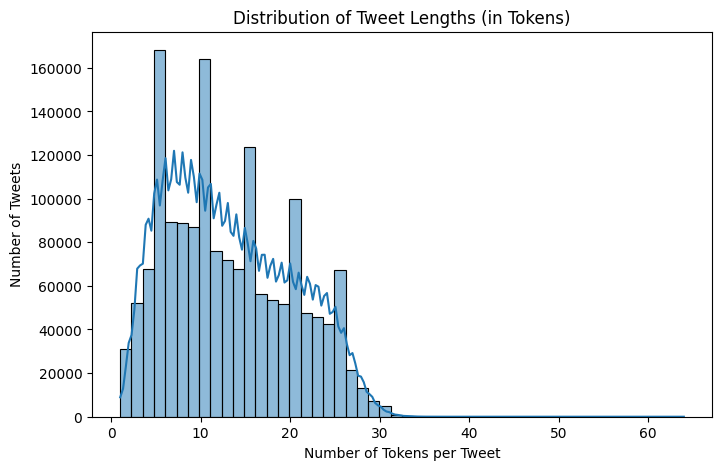

Average tweet length: 13.18
Median tweet length: 12.0
Max tweet length: 64
Min tweet length: 1


In [ ]:
# Simple Tokenization + Vocabulary (for CNN)
print("\n--- Building vocabulary for CNN model ---")

# Whitespace tokenization
tokenized_texts = [t.lower().split() for t in texts]

from collections import Counter

MAX_VOCAB_SIZE = 10000
all_words = [w for sent in tokenized_texts for w in sent]
word_counts = Counter(all_words)
most_common = word_counts.most_common(MAX_VOCAB_SIZE)

# 0 is reserved for <PAD>
vocab = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
vocab["<PAD>"] = 0

print(f"Vocabulary size (including <PAD>): {len(vocab)}")

# Length statistics (for input-length experiments)
tweet_lengths = [len(toks) for toks in tokenized_texts]

plt.figure(figsize=(8, 5))
sns.histplot(tweet_lengths, bins=50, kde=True)
plt.title("Distribution of Tweet Lengths (in Tokens)")
plt.xlabel("Number of Tokens per Tweet")
plt.ylabel("Number of Tweets")
plt.show()

print(f"Average tweet length: {np.mean(tweet_lengths):.2f}")
print(f"Median tweet length: {np.median(tweet_lengths)}")
print(f"Max tweet length: {np.max(tweet_lengths)}")
print(f"Min tweet length: {np.min(tweet_lengths)}")

def encode_sentence(tokens, max_len):
    """Encode a token list into fixed-length integer ids."""
    ids = [vocab.get(w, 0) for w in tokens]
    if len(ids) >= max_len:
        return ids[:max_len]
    else:
        return ids + [0] * (max_len - len(ids))

In [ ]:
# Dataset / Dataloader Helpers
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_val_test_split(encoded_X, labels, train_ratio=0.8, val_ratio=0.1):
    total = len(encoded_X)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))

    X_train = encoded_X[:train_end]
    y_train = labels[:train_end]

    X_val = encoded_X[train_end:val_end]
    y_val = labels[train_end:val_end]

    X_test = encoded_X[val_end:]
    y_test = labels[val_end:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
#  CNN Model Definition (Configurable)
class CNNTextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim=100,
        num_filters=128,
        kernel_size=5,
        depth=1,
        dropout_p=0.5,
    ):
        """
        CNN for text classification.

        depth:  number of stacked convolutional layers.
        All conv layers use the same num_filters and kernel_size.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        convs = []
        in_channels = embed_dim
        for _ in range(depth):
            convs.append(nn.Conv1d(in_channels, num_filters, kernel_size))
            in_channels = num_filters
        self.convs = nn.ModuleList(convs)

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)          # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)         # (batch, embed_dim, seq_len)
        for conv in self.convs:
            x = F.relu(conv(x))        # (batch, num_filters, *)
        x = self.pool(x).squeeze(2)    # (batch, num_filters)
        x = self.dropout(x)
        x = self.fc(x).squeeze(1)      # (batch,)
        return torch.sigmoid(x)

def build_optimizer(model, name="adam", lr=1e-3):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif name == "rmsprop":
        return torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        return torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
#  Early Stopping
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.best_state = None

    def step(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore_best_weights(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

In [ ]:
#  Evaluation Utilities
def evaluate_model(model, loader, device, dataset_name=""):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (outputs > 0.5).int().cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = accuracy_score(y_true, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    total_err = 1 - acc

    print(f"\n{dataset_name} set metrics:")
    print(f"  Accuracy: {acc:.2%}")
    print(f"  FPR: {fpr:.2%}")
    print(f"  FNR: {fnr:.2%}")
    print(f"  Total error: {total_err:.2%}")

    return {
        "accuracy": acc,
        "fpr": fpr,
        "fnr": fnr,
        "total_error": total_err,
        "cm": cm,
    }

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [ ]:
# Single Experiment Runner (Controlled Experiment)
def run_experiment(
    max_seq_len=50,
    embed_dim=100,
    depth=1,
    kernel_size=5,
    batch_size=256,
    lr=0.01,
    optimizer_name="adam",
    num_epochs=20,
    patience=3,
    dropout_p=0.5,
):
    print("\n======================================================")
    print("Starting experiment with configuration:")
    print(
        f"  max_seq_len={max_seq_len}, embed_dim={embed_dim}, depth={depth}, "
        f"kernel_size={kernel_size}, batch_size={batch_size}, lr={lr}, "
        f"optimizer={optimizer_name}, dropout={dropout_p}"
    )
    print("======================================================")

    # 1) Encode with this max_seq_len
    encoded_X = [encode_sentence(tokens, max_seq_len) for tokens in tokenized_texts]

    # 2) Train / Val / Test split
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(
        encoded_X, labels
    )

    train_ds = SentimentDataset(X_train, y_train)
    val_ds = SentimentDataset(X_val, y_val)
    test_ds = SentimentDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    # 3) Build model
    model = CNNTextClassifier(
        vocab_size=len(vocab),
        embed_dim=embed_dim,
        num_filters=128,
        kernel_size=kernel_size,
        depth=depth,
        dropout_p=dropout_p,
    ).to(device)

    optimizer = build_optimizer(model, optimizer_name, lr)
    criterion = nn.BCELoss()

    # Parameter counts
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,} (trainable: {trainable_params:,})")

    early_stopper = EarlyStopping(patience=patience, min_delta=0.0)
    best_epoch = 1  # to record when the best val loss occurred

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | Elapsed: {elapsed:.2f}s"
        )

        # Check early stopping and record best epoch
        prev_best = early_stopper.best_loss
        stop = early_stopper.step(avg_val_loss, model)
        if early_stopper.best_loss is not None and early_stopper.best_loss != prev_best:
            best_epoch = epoch

        if stop:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    total_train_time = time.time() - start_time
    early_stopper.restore_best_weights(model)

    # Final evaluation
    train_metrics = evaluate_model(model, train_loader, device, "Train")
    val_metrics = evaluate_model(model, val_loader, device, "Validation")
    test_metrics = evaluate_model(model, test_loader, device, "Test")

    result = {
        "max_seq_len": max_seq_len,
        "embed_dim": embed_dim,
        "depth": depth,
        "kernel_size": kernel_size,
        "batch_size": batch_size,
        "lr": lr,
        "optimizer": optimizer_name,
        "dropout": dropout_p,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "train_time_sec": total_train_time,
        "early_stop_epoch": best_epoch,   # ★ 추가된 부분
        "train_accuracy": train_metrics["accuracy"],
        "val_accuracy": val_metrics["accuracy"],
        "test_accuracy": test_metrics["accuracy"],
        "val_error": val_metrics["total_error"],
        "test_error": test_metrics["total_error"],
        "test_cm": test_metrics["cm"],
    }

    return result



########## Experiment 1 / 8 ##########

Starting experiment with configuration:
  max_seq_len=50, embed_dim=100, depth=1, kernel_size=5, batch_size=256, lr=0.01, optimizer=adam, dropout=0.5
Total parameters: 1,064,357 (trainable: 1,064,357)
Epoch 01 | Train Loss: 0.4827 | Val Loss: 0.6916 | Elapsed: 766.88s
Epoch 02 | Train Loss: 0.4654 | Val Loss: 0.7493 | Elapsed: 1523.01s
Epoch 03 | Train Loss: 0.4608 | Val Loss: 0.5844 | Elapsed: 2281.35s
Epoch 04 | Train Loss: 0.4584 | Val Loss: 0.6486 | Elapsed: 3044.84s
Epoch 05 | Train Loss: 0.4545 | Val Loss: 0.5982 | Elapsed: 3806.15s
Epoch 06 | Train Loss: 0.4509 | Val Loss: 0.9876 | Elapsed: 4567.44s
Early stopping triggered at epoch 6.

Train set metrics:
  Accuracy: 81.79%
  FPR: 15.51%
  FNR: 22.71%
  Total error: 18.21%

Validation set metrics:
  Accuracy: 74.42%
  FPR: 0.00%
  FNR: 25.58%
  Total error: 25.58%

Test set metrics:
  Accuracy: 73.59%
  FPR: 0.00%
  FNR: 26.41%
  Total error: 26.41%

########## Experiment 2 / 8 ##########

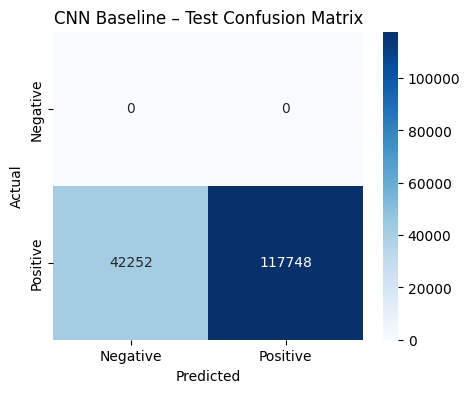

In [ ]:
# Compact Experiment Set (Final)


baseline_cfg = dict(
    max_seq_len=50,        # required input length
    embed_dim=100,         # required embedding size
    depth=1,
    kernel_size=5,         # required kernel size
    batch_size=256,
    lr=0.01,               # required learning rate
    optimizer_name="adam", # one of the required optimizers
    num_epochs=20,         # up to 20 epochs
    patience=3,            # required patience
    dropout_p=0.5,
)

experiment_configs = [
    # 1. Baseline
    baseline_cfg.copy(),

    # 2. Depth experiment: 3 Conv1d layers total
    {**baseline_cfg, "depth": 3},

    # 3. Learning rate experiment: 0.1
    {**baseline_cfg, "lr": 0.1},

    # 4. Batch size experiment: smaller batch
    {**baseline_cfg, "batch_size": 64},

    # 5. Optimizer experiment: SGD
    {**baseline_cfg, "optimizer_name": "sgd"},

    # 6. Kernel size experiment: 3
    {**baseline_cfg, "kernel_size": 3},

    # 7. Embedding dimension experiment: 500
    {**baseline_cfg, "embed_dim": 500},

    # 8. Input length experiment: 250 tokens
    {**baseline_cfg, "max_seq_len": 250},
]

all_results = []

for idx, cfg in enumerate(experiment_configs, start=1):
    print(f"\n########## Experiment {idx} / {len(experiment_configs)} ##########")
    res = run_experiment(**cfg)
    all_results.append(res)

# ===================== SUMMARY TABLE =====================
results_df = pd.DataFrame(all_results)

cols_to_show = [
    "max_seq_len",
    "embed_dim",
    "depth",
    "kernel_size",
    "batch_size",
    "lr",
    "optimizer",
    "dropout",
    "total_params",
    "train_time_sec",
    "early_stop_epoch",
    "train_accuracy",
    "val_accuracy",
    "test_accuracy",
    "val_error",
    "test_error",
]

print("\n===================== SUMMARY TABLE =====================")
print(results_df[cols_to_show])

# Save to CSV for your report
results_df.to_csv("cnn_experiments_results_compact.pdf_version.csv", index=False)
print("\nSaved summary to cnn_experiments_results_compact.pdf_version.csv")

# Example confusion matrix: baseline (Experiment 1)
plot_confusion_matrix(
    all_results[0]["test_cm"],
    title="CNN Baseline – Test Confusion Matrix"
)



